# Artificial Analysis

In [9]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import sys
import gpflow
import gpflow.kernels as k
import tensorflow as tf
from copy import deepcopy
from gpflow.config import default_float
from gpflow.base import TensorType
from check_shapes import check_shapes, inherit_check_shapes

sys.path.append( './helper/' )
from Colormap import Colormap
from GPHelper import LinearNoise

In [10]:
plt.rcParams['text.usetex'] = True
baseFigurePath = './tmp/figures'

In [11]:
class Gamma2DGeneric(gpflow.functions.MeanFunction, gpflow.functions.Function):
    """
    y_i = A * x0_i ** gamma + b
    """

    @check_shapes(
        "A: [broadcast D, broadcast Q]",
        "b: [broadcast Q]",
    )
    def __init__(self, A: TensorType = None, b: TensorType = None, gamma: TensorType = None) -> None:
        """
        A is a matrix which maps each element of X to Y, b is an additive
        constant and gamma the gamma element.
        """
        gpflow.functions.MeanFunction.__init__(self)
        A = np.ones((1, 1), dtype=default_float()) if A is None else A
        b = np.zeros(1, dtype=default_float()) if b is None else b
        gamma = 2.2 if gamma is None else gamma
        self.A = gpflow.Parameter(np.atleast_2d(A))
        self.b = gpflow.Parameter(b)
        self.gamma = gpflow.Parameter(gamma)

    @inherit_check_shapes
    def __call__(self, X: TensorType) -> tf.Tensor:
        X1 = X[:, 0]
        X1 = tf.reshape(X1, (-1, 1))

        return tf.tensordot(X1**self.gamma, self.A, [[-1], [0]]) + self.b

In [12]:
class Temp2DGeneric(gpflow.functions.MeanFunction, gpflow.functions.Function):
    """
    y_i = c + A *  (x0_i * x1_i - x0_i**2 * x1_i)
    """

    @check_shapes(
        "c: [broadcast Q]",
        "A: [broadcast D, broadcast Q]",
    )
    def __init__(self, c: TensorType = None, A: TensorType = None) -> None:
        """
        A is a matrix which maps each element of X to Y, b is an additive
        constant c.
        """
        gpflow.functions.MeanFunction.__init__(self)
        c = np.zeros(1, dtype=default_float()) if c is None else c
        A = np.ones((1, 1), dtype=default_float()) if A is None else A
        self.c = gpflow.Parameter(c)
        self.A = gpflow.Parameter(np.atleast_2d(A))

    @inherit_check_shapes
    def __call__(self, X: TensorType) -> tf.Tensor:
        X0 = X[:, 0]
        X0 = tf.reshape(X0, (-1, 1))
        X1 = X[:, 1]
        X1 = tf.reshape(X1, (-1, 1))

        return self.c + tf.tensordot(X0*X1, self.A, [[-1], [0]]) + tf.tensordot(X0**2*X1, -self.A, [[-1], [0]]) 

In [13]:
def fitApproach(df, numberdatapoints, cuts, kernel, mean_funct=None, likelihood=None, iterationlimit=300, method='L-BFGS-B', showStd=False, path='tmp'):
    # sort df
    df = df.sort_values(by='L_in')
    # cut df
    df = df[ df['L_in'] >= cuts[0]]
    df = df[df['L_in'] <= cuts[1]]
    print(f' slice: {cuts}')

    # extract data
    indices = np.linspace(0, len(df['L_in'])-1, numberdatapoints, dtype=int)
    print(f' num. training points: {len(indices)}')

    X_train = np.array(df.iloc[indices][['L_in', 'temps']])
    Y_train = np.array(df.iloc[indices][['L_out']])

    # create and train model
    if not likelihood:
        model = gpflow.models.GPR((X_train, Y_train), kernel=deepcopy(kernel), mean_function=mean_funct, noise_variance=1e-3)
    else: 
        model = gpflow.models.GPR((X_train, Y_train), kernel=deepcopy(kernel), mean_function=mean_funct, likelihood=likelihood)
    opt = gpflow.optimizers.Scipy()
    summary = opt.minimize(model.training_loss, model.trainable_variables, method=method, options={'maxiter': iterationlimit})
    print(summary)
    
    gpflow.utilities.print_summary(model, fmt='notebook')
    try:
        print(model.mean_function.variables)
    except:
        print("no w")

    # 4. Compare
    mean_predictions, var_predictions = model.predict_y(np.array(df[['L_in', 'temps']]))
    std_predictions = np.sqrt(var_predictions)
    mean_predictions_n = np.asarray(mean_predictions, dtype=float)
    std_predictions_n = np.asarray(std_predictions, dtype=float)

    # first graph
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,5), layout='constrained', subplot_kw={'projection': '3d'})
    fontsize = 18
    # test
    axes.scatter(df[['L_in']], df[['temps']], df[['L_out']], s=1, alpha=0.5, color=Colormap.map[0], label='artificial data points')
    # prediction
    axes.scatter(df[['L_in']], df[['temps']], mean_predictions[:,0], s=1, label=f' prediction by GP (max std: {std_predictions_n[:,0].max():.3f})', color=Colormap.map[1])
    print(f'prediction by GP (max std: {std_predictions_n[:,0].max():.3f})')
    #train
    axes.scatter(X_train[:,0], X_train[:,1], Y_train, s=10, color=Colormap.black)
    axes.set_xlabel(r'$L_{in}$', fontsize=fontsize)
    axes.set_ylabel(r'temp [°C]', fontsize=fontsize)
    axes.set_zlabel(r'$L_{out} \left[\frac{cd}{m^2}\right]$', fontsize=fontsize)
    axes.view_init(elev=35, azim=-120);

    figurePath = f'{baseFigurePath}/{path}_A.png'
    fig.show()
    fig.savefig(figurePath, dpi=300)

    # second graph
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,5), layout='constrained')
    fontsize = 18
    pcm = axes.scatter(df['L_in'], df['L_out']-mean_predictions_n[:,0], s=1, c=df['temps'], cmap='coolwarm', label=f'mean of residuen: {(df["L_out"]-mean_predictions_n[:,0]).mean():.3}\nstd. of residuen: {(df["L_out"]-mean_predictions_n[:,0]).std():.3}')
    print(f'mean of residuen: {(df["L_out"]-mean_predictions_n[:,0]).mean():.3}\nstd. of residuen: {(df["L_out"]-mean_predictions_n[:,0]).std():.3}')
    axes.scatter(X_train[:,0], df.iloc[indices]['L_out']-mean_predictions_n[indices][:,0], s=10, color=Colormap.black)
    axes.fill_between(
            df['L_in'],
            - 1.96 * std_predictions_n[:,0],    # 95% prediction interval ~2 sigma
            + 1.96 * std_predictions_n[:,0],
            color=Colormap.map[1],
            alpha=0.2,
        )


    axes.set_xlabel(r'$L_{in}$', fontsize=fontsize)
    axes.set_ylabel(r'$L_{out}$ $\left[\frac{cd}{m^2}\right]$', fontsize=fontsize)
    # set label for colorbar
    ax2 = axes.twinx()
    ax2.set_yticks([])
    ax2.set_ylabel(r'temperature $\left[^{\circ}C\right]$', fontsize=fontsize)
    fig.colorbar(pcm)
    
    figurePath = f'{baseFigurePath}/{path}_B.png'
    fig.show()
    fig.savefig(figurePath, dpi=300)

## Gamma (Figure 5.1)

 slice: [0.0, 1]
 num. training points: 64


2024-01-23 17:48:25.134428: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-01-23 17:48:25.135312: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-01-23 17:48:25.136022: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 64.57029503799225
        x: [ 1.300e+04 -3.168e+01  2.068e+00 -2.541e-02  9.503e+01
             2.401e-01  2.200e+00]
      nit: 217
      jac: [ 4.854e-26  8.862e-09  2.191e-04 -1.322e-03 -2.860e-05
             1.763e-03  9.892e-04]
     nfev: 361
     njev: 361
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[95.0302]]
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.24007]
GPR.mean_function.gamma,Parameter,Identity,,True,(),float64,2.19965
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,12999.18782
GPR.likelihood.scale.A,Parameter,Identity,,True,"(1, 1)",float64,[[2.06806]]
GPR.likelihood.scale.c,Parameter,Identity,,True,"(1,)",float64,[-0.02541]


(<tf.Variable 'Variable:0' shape=(1, 1) dtype=float64, numpy=array([[95.03019963]])>, <tf.Variable 'Variable:0' shape=(1,) dtype=float64, numpy=array([0.24006601])>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1996479855328945>)
prediction by GP (max std: 2.043)


/tmp/ipykernel_148941/184827308.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


mean of residuen: -0.0226
std. of residuen: 1.15


/tmp/ipykernel_148941/184827308.py:97: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


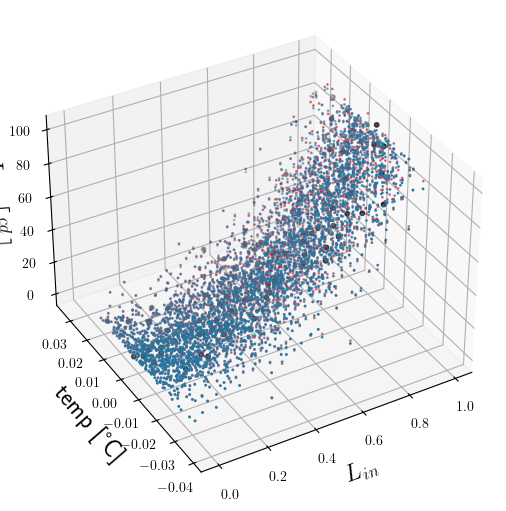

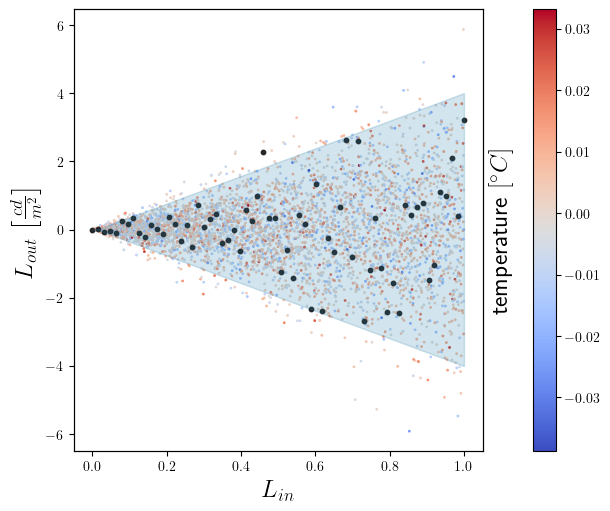

In [15]:
resolution = 2**12
df = pd.DataFrame()
X = np.linspace(0.0, 1.0, resolution)
df['L_in'] = X
df['temps'] = np.zeros(resolution) + np.random.normal(loc=0, scale=0.01, size=resolution)
df['L_out'] = 0.24+95*X**2.2 + np.random.normal(loc=0, scale=X*2, size=resolution)

kernel = k.SquaredExponential()
mean_funct = Gamma2DGeneric(gamma=2.0)
likelihood = gpflow.likelihoods.Gaussian(scale=LinearNoise())

fitApproach(df, 64, [0.0, 1], kernel=kernel, mean_funct=mean_funct, likelihood=likelihood, iterationlimit=1000, showStd=True, path='04Artificial/GammaMeanFunction')

## Figure 5.2

In [16]:
resolution = 2**9

# function to create data
def tempponly(x, t, w):
    return w[0] + w[1]*(x*t - x**2*t)


X = np.linspace(0.0, 1.0, resolution)
temps = np.random.permutation((4*np.linspace(30, 40, resolution)).round() / 4)
temps = np.random.permutation(np.linspace(30, 40, resolution))
tempmin = temps.min()
temprange = temps.max()-tempmin
tnorm = (temps-tempmin)/temprange
w = [0, 130]

df = pd.DataFrame()
df['L_in'] = X
df['temps'] = temps
df['L_out'] = tempponly(df['L_in'], tnorm, w)

X, Y = np.meshgrid(X, temps)
Z = tempponly(X, (Y-Y.min())/(Y.max()-Y.min()), w)

/tmp/ipykernel_148941/1469852182.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


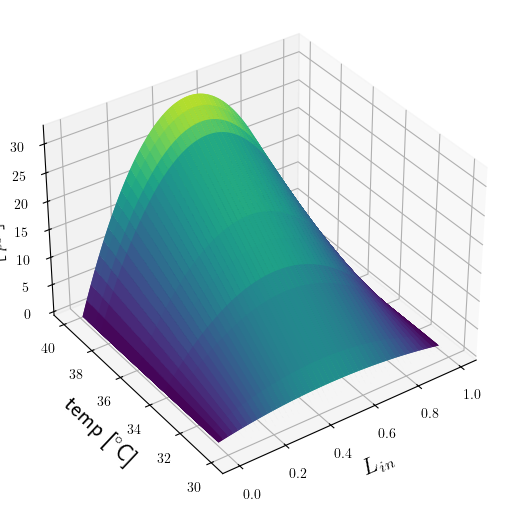

In [17]:
#plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,5), layout='constrained', subplot_kw={'projection': '3d'})
fontsize = 17

axes.plot_surface(X, Y, Z, cmap=plt.cm.viridis, antialiased=True)

axes.set_xlabel(r'$L_{in}$', fontsize=fontsize)
axes.set_ylabel(r'temp [$^\circ$C]', fontsize=fontsize)
axes.set_zlabel(r'$\Delta_{L_{out}} \left[\frac{cd}{m^2}\right]$', fontsize=fontsize)
axes.view_init(elev=35, azim=-125);

path='04Artificial/TempEffectShape'

figurePath = f'{baseFigurePath}/{path}.png'
fig.show()
fig.savefig(figurePath, dpi=300)

## Figure 5.3

 slice: [0.0, 1]
 num. training points: 256
  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: -32.0530529494165
        x: [ 2.461e+00  9.817e+03  3.139e-01 -7.543e-03  1.428e+00
            -2.783e+02]
      nit: 58
      jac: [ 1.184e-02 -2.895e-03  1.219e-02  1.404e-01 -7.027e-03
            -1.021e-01]
     nfev: 137
     njev: 137
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[-278.34773]
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[1.42821]]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,9816.92051
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,2.54326
GPR.likelihood.scale.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.31387]]
GPR.likelihood.scale.c,Parameter,Identity,,True,"(1,)",float64,[-0.00754]


(<tf.Variable 'Variable:0' shape=(1, 1) dtype=float64, numpy=array([[1.4282118]])>, <tf.Variable 'Variable:0' shape=(1,) dtype=float64, numpy=array([-278.34773367])>)
prediction by GP (max std: 0.415)


/tmp/ipykernel_148941/184827308.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


mean of residuen: 0.00946
std. of residuen: 0.187


/tmp/ipykernel_148941/184827308.py:97: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


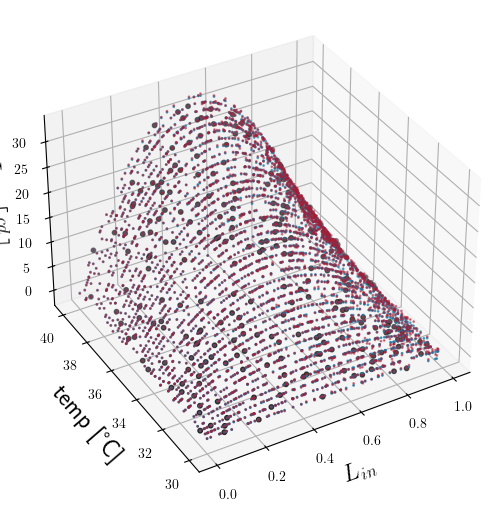

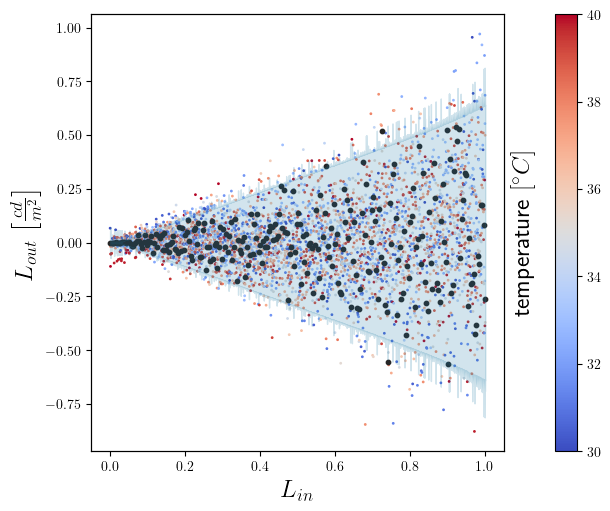

In [18]:
resolution = 2**12
df = pd.DataFrame()
X = np.linspace(0.0, 1.0, resolution)
temps = np.random.permutation((4*np.linspace(30, 40, resolution)).round() / 4)
tempmin = temps.min()
temprange = temps.max()-tempmin
tnorm = (temps-tempmin)/temprange
w = [0, 130]

df['L_in'] = X
df['temps'] = temps
df['L_out'] = tempponly(df['L_in'], tnorm, w) + np.random.normal(loc=0, scale=X*0.3, size=resolution)

kernel = k.SquaredExponential()
mean_funct = Temp2DGeneric()
likelihood = gpflow.likelihoods.Gaussian(scale=LinearNoise())

fitApproach(df, 256, [0.0, 1], kernel=kernel, mean_funct=mean_funct, likelihood=likelihood, iterationlimit=1000, showStd=True, path='04Artificial/TempMeanFunction')

## Figure 5.4

 slice: [0.0, 1]
 num. training points: 64
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 155.76662499829837
        x: [ 3.312e+00  3.876e+01  1.594e+00  1.628e+00  2.117e+00
            -2.680e-01]
      nit: 36
      jac: [ 1.074e-05  1.271e-06  3.539e-06 -1.055e-04  9.707e-05
            -8.516e-06]
     nfev: 44
     njev: 44
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[-0.26802]
GPR.mean_function.A,Parameter,Identity,,True,"(1, 1)",float64,[[2.11737]]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,38.75617
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,3.34774
GPR.likelihood.scale.A,Parameter,Identity,,True,"(1, 1)",float64,[[1.59382]]
GPR.likelihood.scale.c,Parameter,Identity,,True,"(1,)",float64,[1.62813]


(<tf.Variable 'Variable:0' shape=(1, 1) dtype=float64, numpy=array([[2.11737379]])>, <tf.Variable 'Variable:0' shape=(1,) dtype=float64, numpy=array([-0.26801875])>)
prediction by GP (max std: 3.437)


/tmp/ipykernel_148941/184827308.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


mean of residuen: -0.0895
std. of residuen: 2.41


/tmp/ipykernel_148941/184827308.py:97: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


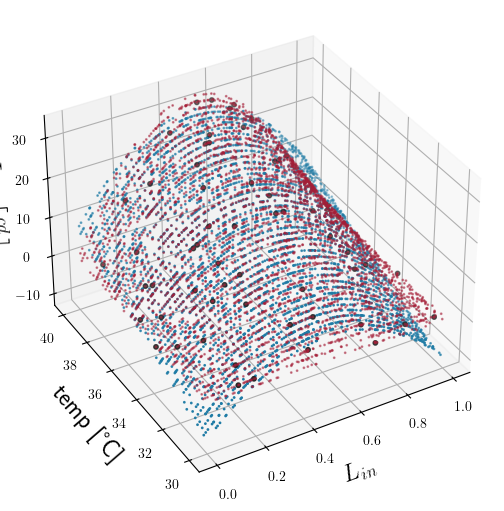

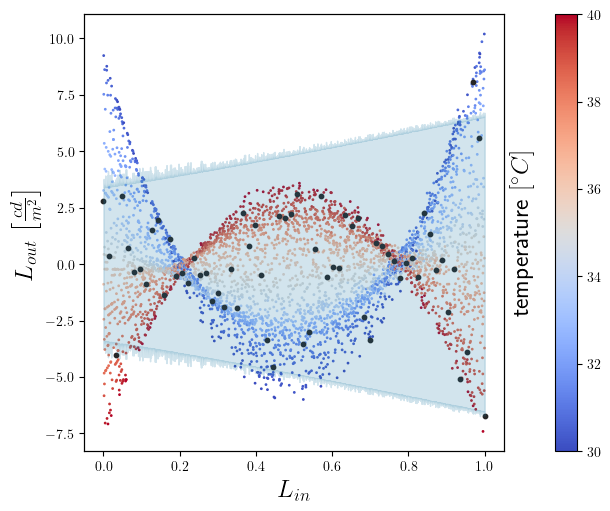

In [19]:
df = pd.DataFrame()
X = np.linspace(0.0, 1.0, resolution)
temps = np.random.permutation((4*np.linspace(30, 40, resolution)).round() / 4)
tempmin = temps.min()
temprange = temps.max()-tempmin
tnorm = (temps-tempmin)/temprange
w = [0, 130]

df['L_in'] = X
df['temps'] = temps
df['L_out'] = tempponly(df['L_in'], tnorm, w) + np.random.normal(loc=0, scale=X*0.3, size=resolution)

kernel = k.SquaredExponential()
mean_funct = Temp2DGeneric()
likelihood = gpflow.likelihoods.Gaussian(scale=LinearNoise())

fitApproach(df, 64, [0.0, 1], kernel=kernel, mean_funct=mean_funct, likelihood=likelihood, iterationlimit=1000, showStd=True, path='04Artificial/TempMeanFunction64')

## Figure 5.5

 slice: [0.0, 1]
 num. training points: 1024


/home/jonas/Documents/GithubRepo/_venv_/lib/python3.11/site-packages/gpflow/optimizers/scipy.py:152: OptimizeWarning: Unknown solver options: maxiter
  opt_result = scipy.optimize.minimize(


 message: Max. number of function evaluations reached
 success: False
  status: 3
     fun: -549.5374728382994
       x: [ 1.404e+00  4.103e+03  2.961e-01  2.347e-04  7.656e+01
            8.153e-01  2.306e+00 -2.722e+00  8.153e-01]
     nit: 16
     jac: [-7.231e+01  8.337e-04 -9.731e+01 -2.333e+03  1.036e-01
            2.585e-02 -1.222e+01 -4.967e+00  2.585e-02]
    nfev: 101


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.add_1.A,Parameter,Identity,,True,"(1, 1)",float64,[[76.55962]]
GPR.mean_function.add_1.b,Parameter,Identity,,True,(),float64,0.81526
GPR.mean_function.add_1.gamma,Parameter,Identity,,True,(),float64,2.30606
GPR.mean_function.add_2.c,Parameter,Identity,,True,(),float64,0.81526
GPR.mean_function.add_2.A,Parameter,Identity,,True,"(1, 1)",float64,[[-2.72183]]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,4103.4693
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.62392
GPR.likelihood.scale.A,Parameter,Identity,,True,"(1, 1)",float64,[[0.29608]]
GPR.likelihood.scale.c,Parameter,Identity,,True,(),float64,0.00023


(<tf.Variable 'Variable:0' shape=(1, 1) dtype=float64, numpy=array([[76.55962347]])>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.8152569197057155>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3060633068777507>, <tf.Variable 'Variable:0' shape=(1, 1) dtype=float64, numpy=array([[-2.72183345]])>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.8152569197057155>)
prediction by GP (max std: 0.424)


/tmp/ipykernel_148941/184827308.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


mean of residuen: 0.00062
std. of residuen: 0.173


/tmp/ipykernel_148941/184827308.py:97: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


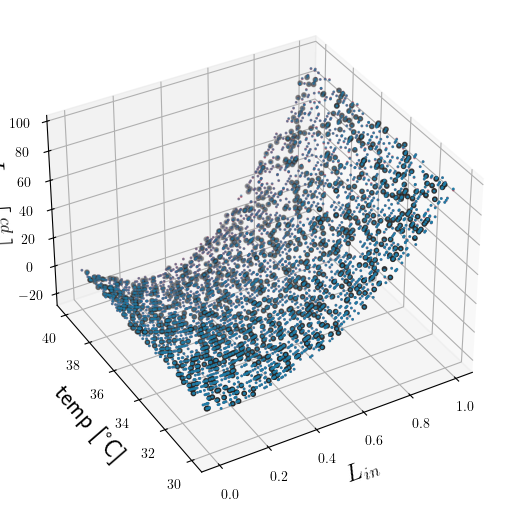

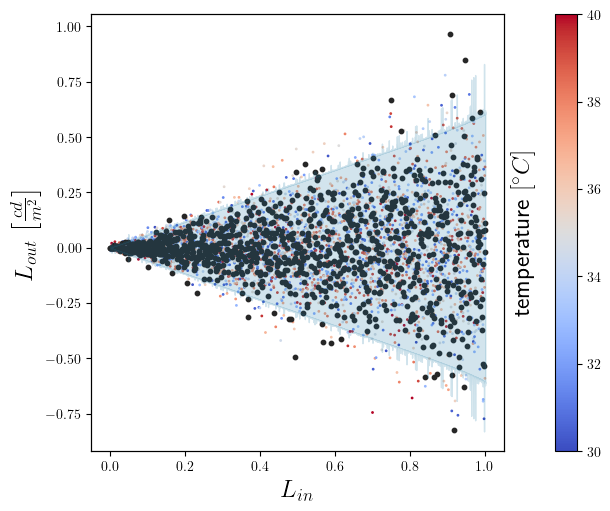

In [20]:
df = pd.DataFrame()
X = np.linspace(0.0, 1.0, resolution)
temps = np.random.permutation((4*np.linspace(30, 40, resolution)).round() / 4)
tempmin = temps.min()
temprange = temps.max()-tempmin
tnorm = (temps-tempmin)/temprange
w = [0, 130]

df['L_in'] = X
df['temps'] = temps
df['L_out'] = (0.24 + 95 * X **2.2) - tempponly(df['L_in'], tnorm, w) + np.random.normal(loc=0, scale=X*0.3, size=resolution)

kernel = k.SquaredExponential(variance=1699, lengthscales=1.2)
mean_funct = Gamma2DGeneric(A=12, b=0.8, gamma=3.3) + Temp2DGeneric(c=0.8, A=-2.8)
likelihood = gpflow.likelihoods.Gaussian(scale=LinearNoise(A=0.28, c=0.0006))

fitApproach(df, 1024, [0.0, 1], kernel=kernel, mean_funct=mean_funct, likelihood=likelihood, method='TNC', iterationlimit=1000, showStd=True, path='04Artificial/BothMeanFunction')